In [1]:
import os
import spacy
import warnings
import wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import textstat
import spacy
nlp = spacy.load('en_core_web_sm')

from spacy import displacy
from nltk.tokenize import sent_tokenize, word_tokenize 

import warnings
warnings.filterwarnings("ignore")

import contractions
import nltk
import string

#nltk.download('stopwords')
#from nltk.corpus import stopwords
#stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')
import pkg_resources
from symspellpy import SymSpell, Verbosity

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwariyagupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/aishwariyagupta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
patient_notes = pd.read_csv("patient_notes.csv")
#one case number has many pn_num
features = pd.read_csv("features.csv")
#one case has many feature_num
train = pd.read_csv("train.csv")

train = train.merge(features, on=['feature_num', 'case_num'], how='left')
train = train.merge(patient_notes, on=['pn_num', 'case_num'], how='left')

pd.set_option('display.max_colwidth', None)

### Pre-processing the text column to clean it

In [3]:
train["pn_history_lower"] = train["pn_history"].str.lower()
regex = re.compile(r'<[^>]+>')
train["pn_history_noContractions"] = train["pn_history_lower"].apply(contractions.fix)

def remove_unicode_chars(text):
    text = text.encode("ascii", "ignore").decode()
    return text
train["pn_history_noUnicode"] = train["pn_history_noContractions"].apply(remove_unicode_chars)

def remove_punctuations(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), " ",text)
    return text
train["pn_history_noPuncts"] = train["pn_history_noUnicode"].apply(remove_punctuations)

#def remove_stopwords(text):
#    return " ".join([word for word in str(text).split() if word not in stop_words])
#train["tweet_noStopwords"] = train["tweet_noPuncts"].apply(remove_stopwords)
def remove_extra_spaces(text):
    text = re.sub(' +', ' ', text).strip()
    return text
train["pn_history_noES"] = train["pn_history_noPuncts"].apply(remove_extra_spaces)
def lemmatize_text(text):
    words = [lemmatizer.lemmatize(word) for word in text.split()]
    text = ' '.join(words)
    return text
train["pn_history_preprocessed"] = train["pn_history_noES"].apply(lemmatize_text)

In [4]:
train = train.drop_duplicates(["pn_history_preprocessed"])

In [5]:
train.shape

(1000, 14)

## Model 4 : KeyBert with BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext

In [7]:
from keybert import KeyBERT
from tqdm import tqdm

In [8]:
model = KeyBERT(model="microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")

No sentence-transformers model found with name /Users/aishwariyagupta/.cache/torch/sentence_transformers/microsoft_BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/aishwariyagupta/.cache/torch/sentence_transformers/microsoft_BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initia

## Applying KEYBERT Model

## Extracting 2 keywords

In [11]:
l = []
for index, row in tqdm(train.iterrows()):
    l.append(model.extract_keywords(
                row['pn_history_preprocessed'],
                top_n=3, 
                keyphrase_ngram_range=(1, 2),
                use_mmr=True, 
                diversity=0.7))

1000it [16:32,  1.01it/s]


In [12]:
train = train.reset_index(drop=True)

In [13]:
train = train.join(pd.DataFrame(l, columns=['first_keyword', 'second_keyword', 'third_keyword']))

In [14]:
train.to_csv("two_keywords_extraction_biomedNLP.csv")

In [15]:
#seprating keyword along with cosine similarity
def func(x):
    return x[1]
train['first_keyword_score'] = train.first_keyword.apply(lambda x: func(x))
def func(x):
    return x[0]
train['first_keyword'] = train.first_keyword.apply(lambda x: func(x))

def func(x):
    return x[1]
train['second_keyword_score'] = train.second_keyword.apply(lambda x: func(x))
def func(x):
    return x[0]
train['second_keyword'] = train.second_keyword.apply(lambda x: func(x))

def func(x):
    return x[1]
train['third_keyword_score'] = train.third_keyword.apply(lambda x: func(x))
def func(x):
    return x[0]
train['third_keyword'] = train.third_keyword.apply(lambda x: func(x))

In [16]:
train.to_csv("two_keywords_extraction_with_score_biomedNLP.csv")

## Extracting 3 keywords

In [17]:

l = []
for index, row in tqdm(train.iterrows()):
    l.append(model.extract_keywords(
                row['pn_history_preprocessed'],
                top_n=3,
                keyphrase_ngram_range=(1, 3),
                use_mmr=True, 
                diversity=0.7))

1000it [24:15,  1.46s/it]


In [18]:
train_new = train.join(pd.DataFrame(l, columns=['first_keyword_three', 'second_keyword_three', 'third_keyword_three']))

In [19]:
train.to_csv("three_keywords_extraction_biomedNLP.csv")

In [20]:
def func(x):
    return x[1]
train_new['first_keyword_score_three'] = train_new.first_keyword_three.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new['first_keyword_three'] = train_new.first_keyword_three.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new['second_keyword_score_three'] = train_new.second_keyword_three.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new['second_keyword_three'] = train_new.second_keyword_three.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new['third_keyword_score_three'] = train_new.third_keyword_three.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new['third_keyword_three'] = train_new.third_keyword_three.apply(lambda x: func(x))

In [21]:
train_new[["first_keyword_score_three","first_keyword_three","second_keyword_three","second_keyword_score_three","third_keyword_three","third_keyword_score_three"]].sample(10)

,first_keyword_score_three,first_keyword_three,second_keyword_three,second_keyword_score_three,third_keyword_three,third_keyword_score_three
219,0.9550,sweating episode drenching,social tobacco,0.9157,mom ha osteoarthritis,0.9017
905,0.9610,drink wekend sexually,ha associated photophobia,0.9333,week alcohol drink,0.9055
796,0.9657,sexually active boyfriiebds,intolderence,0.9157,using condom,0.9078
131,0.9594,achy pain rate,ha helped,0.9189,med allergy,0.9136
251,0.9564,irregular period 3yrs,fh mother overweight,0.9175,moderate,0.9080
666,0.9663,albuterol help wopke,mi grandfather,0.9192,significant,0.8923
192,0.9597,diarrhea started day,fh parent healthy,0.9106,nonsmoker,0.9086
160,0.9572,non bloody diarrhea,travel ibuprofen helped,0.9266,med ibuprofen,0.9076
544,0.9532,cold intolerance associated,racing past week,0.9352,year old female,0.9334
563,0.9596,patient endorses shortness,monogamous relationship,0.9337,condo stressed,0.8959


In [22]:
train.to_csv("three_keywords_extraction_with_score_biomedNLP.csv")

## Extracting 4 keywords

In [23]:
l = []
for index, row in tqdm(train.iterrows()):
    l.append(model.extract_keywords(
                row['pn_history_preprocessed'],
                top_n=3,
                keyphrase_ngram_range=(1, 4),
                use_mmr=True, 
                diversity=0.7))

1000it [32:50,  1.97s/it]


In [24]:
train_new['third_keyword_score_three'] = train_new['third_keyword_score']

In [25]:
train_new_new = train_new.join(pd.DataFrame(l, columns=['first_keyword_four', 'second_keyword_four', 'third_keyword_four']))


In [26]:
train_new_new.to_csv("four_keywords_extraction_biomedNLP.csv")

In [27]:
def func(x):
    return x[1]
train_new_new['first_keyword_score_four'] = train_new_new.first_keyword_four.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new_new['first_keyword_four'] = train_new_new.first_keyword_four.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new_new['second_keyword_score_four'] = train_new_new.second_keyword_four.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new_new['second_keyword_four'] = train_new_new.second_keyword_four.apply(lambda x: func(x))

def func(x):
    return x[1]
train_new_new['third_keyword_score_four'] = train_new_new.third_keyword_four.apply(lambda x: func(x))
def func(x):
    return x[0]
train_new_new['third_keyword_four'] = train_new_new.third_keyword_four.apply(lambda x: func(x))

In [28]:
train_new_new[["first_keyword_score_four","first_keyword_four","second_keyword_score_four","second_keyword_four","third_keyword_three","third_keyword_score_three"]].sample(10)

,first_keyword_score_four,first_keyword_four,second_keyword_score_four,second_keyword_four,third_keyword_three,third_keyword_score_three
38,0.9645,17yom presenting palpitation started,0.9241,marijuana used,thyroid issue,0.9164
692,0.9657,denies difficulty urinating tried,0.9371,albuterol tylenol,mi alive med,0.9210
194,0.9582,onset 10 hour ago,0.9331,20 year old female,drink alcohol,0.9148
309,0.9623,pmh pain managed conservativly,0.9428,uncle bledding,chest,0.9181
603,0.9660,endorses stuffy nose muscle,0.9140,fh heart attack,female sexual partner,0.9171
340,0.9648,bloating increased saitey small,0.9228,help make worse,recent divorce,0.9159
305,0.9609,bloating partially relieved tum,0.9234,divorce year work,20 year smoker,0.9025
8,0.9737,lightheadedness episode denies,0.9157,drug use alcohol use,os,0.9154
575,0.9641,denies feeling depressed pmhx,0.9230,consultant looking,purchaesd condo,0.9010
200,0.9641,lubricant complains dyspareunia fever,0.9270,smoke use drug drink,htn hctz,0.9150


In [29]:
train_new_new.to_csv("all_keywords_with_score_biomedNLP.csv")

In [31]:
train_with_scores = train_new_new.copy()

In [32]:
train_with_scores = pd.read_csv("all_keywords_with_score_biomedNLP.csv")

In [33]:
train_with_scores = train_with_scores[['id', 'case_num', 'pn_num', 'feature_num', 'annotation', 'location', 'feature_text', 'pn_history', 'pn_history_lower', 'pn_history_noContractions', 'pn_history_noUnicode', 'pn_history_noPuncts', 'pn_history_noES', 'pn_history_preprocessed', 'first_keyword', 'second_keyword', 'third_keyword', 'first_keyword_score', 'second_keyword_score', 'third_keyword_score', 'first_keyword_three', 'second_keyword_three', 'third_keyword_three', 'first_keyword_score_three', 'second_keyword_score_three', 'third_keyword_score_three', 'first_keyword_four', 'second_keyword_four', 'third_keyword_four', 'first_keyword_score_four', 'second_keyword_score_four', 'third_keyword_score_four']]

In [34]:
train_with_scores = train_with_scores.iloc[:,14:]

In [35]:
train_with_scores.first_keyword_score.quantile([0.25, 0.5, 0.75, 0.9])

0.25    0.9488
0.50    0.9517
0.75    0.9546
0.90    0.9569
Name: first_keyword_score, dtype: float64

In [36]:
train_with_scores.second_keyword_score.quantile([0.25, 0.5, 0.75, 0.9])

0.25    0.91950
0.50    0.92515
0.75    0.93070
0.90    0.93580
Name: second_keyword_score, dtype: float64

In [37]:
train_with_scores.third_keyword_score.quantile([0.25, 0.5, 0.75, 0.9])

0.25    0.90450
0.50    0.91315
0.75    0.91930
0.90    0.92480
Name: third_keyword_score, dtype: float64

### Selecting those keywords which have a cosine similarity more than 0.25

In [38]:
train_with_scores.first_keyword = np.where(train_with_scores.first_keyword_score > 0.25, train_with_scores.first_keyword, np.nan)
train_with_scores.second_keyword = np.where(train_with_scores.second_keyword_score > 0.25, train_with_scores.second_keyword, np.nan)
train_with_scores.third_keyword = np.where(train_with_scores.third_keyword_score > 0.25, train_with_scores.third_keyword, np.nan)

In [39]:
train_with_scores.first_keyword_score.median(), train_with_scores.second_keyword_score.median(), train_with_scores.third_keyword_score.median()


(0.9517, 0.92515, 0.91315)

In [40]:
train_with_scores.first_keyword_three = np.where(train_with_scores.first_keyword_score_three > 0.25, train_with_scores.first_keyword_three, np.nan)
train_with_scores.second_keyword_three = np.where(train_with_scores.second_keyword_score_three > 0.25, train_with_scores.second_keyword_three, np.nan)
train_with_scores.third_keyword_three = np.where(train_with_scores.third_keyword_score_three > 0.25, train_with_scores.third_keyword_three, np.nan)


In [41]:
train_with_scores.first_keyword_four = np.where(train_with_scores.first_keyword_score_four > 0.25, train_with_scores.first_keyword_four, np.nan)
train_with_scores.second_keyword_four = np.where(train_with_scores.second_keyword_score_four > 0.25, train_with_scores.second_keyword_four, np.nan)
train_with_scores.third_keyword_four = np.where(train_with_scores.third_keyword_score_four > 0.25, train_with_scores.third_keyword_four, np.nan)


In [42]:
train_new_new = pd.read_csv("all_keywords_with_score_biomedNLP.csv")

In [43]:
train_with_scores = train_new_new[['id', 'pn_num', 'pn_history_preprocessed']].join(train_with_scores)

In [44]:
train_with_scores[:1].third_keyword.values

array(['week weekend'], dtype=object)

### Predicting Annotations

In [45]:
def func(x):
    all_annotation = []
    for annotation in [x.first_keyword, x.second_keyword, x.third_keyword, 
                       x.first_keyword_three, x.second_keyword_three, x.third_keyword_three,
                       x.first_keyword_four, x.second_keyword_four, x.third_keyword_four]:
        
        if str(annotation) != 'nan':
            all_annotation.append(str(annotation))
    return list(set(all_annotation))
    
train_with_scores['predicted_annotation'] = train_with_scores.apply(lambda x: func(x), axis=1)

In [46]:
train_with_scores[['pn_num', 'predicted_annotation']]

,pn_num,predicted_annotation
0,16,"[recent soccer, lose conciousness, night week weekend, mom thyroid disease, diaphoresis fever chill, patient endorses abusing adderall, endorses abusing adderall, week weekend]"
1,41,"[using condom, hosp travel trauma, clinic heart pounding started, etoh, heart pounding started, pounding started]"
2,46,"[wa consented, cleveland, ago described feeling nervousness, thyroid issue, headedness sob, sex gf use, wa consented parent, make palpitation worse]"
3,82,"[pounding pt, female partner, report ha helped, sexually active female partner, heart pounding pt, report adverse, episodic heart pounding pt, father mi mom, female partner condom]"
4,100,"[cleveland, experienced symptom, bowel urinary habit, rapid pounding heart, pounding heart beat denies, use etoh use drink, rapid pounding, soc tobacco use]"
...,...,...
995,95145,"[pt state, ibuprofen tylenol, sound aura state, yesterday morning, ha neck pain, progressively getthing, headache yesterday, vomitting x3 food green]"
996,95228,"[surgery instrumentation, x2 day sick contact, day uri, spinal surgery instrumentation, headache photosensitivity, severe headache, sick contact utd, vaccine hx]"
997,95243,"[dull headache, headache patient said started, headache patient said, joint marijuana week etoh, yesterday morning, use soical, marijuana week etoh]"
998,95330,"[female, make pain worse ha, pain felt, ha ibuprofen tylenol, alcohol use, significant, felt head nonpulsating, yesterday]"


In [47]:
train_with_scores.to_csv("final_annotations_biomedNLP")

In [44]:
## using Fuzzy Wuzzy

### Evaluation Phase 1: Using Fuzzy Wuzzy techniques

In [48]:
train_with_scores = pd.read_csv("final_annotations_biomedNLP",index_col=[0])

In [49]:
from thefuzz import fuzz
from thefuzz import process

In [50]:
patient_notes_test = pd.read_csv("patient_notes.csv")
#one case number has many pn_num
features_test = pd.read_csv("features.csv")
#one case has many feature_num
test = pd.read_csv("train.csv")
test = test.merge(features_test, on=['feature_num', 'case_num'], how='left')
test = test.merge(patient_notes_test, on=['pn_num', 'case_num'], how='left')
test = test.merge(train_with_scores[['pn_num', 'pn_history_preprocessed']], on=['pn_num'], how='left')
pd.set_option('display.max_colwidth', None)
display(test.head(2))

,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history,pn_history_preprocessed
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms",hpi 17yo m present with palpitation patient report 3 4 month of intermittent episode of heart beating pounding out of my chest 2 day ago during a soccer game had an episode but this time had chest pressure and felt a if he were going to pas out did not lose conciousness of note patient endorses abusing adderall primarily to study 1 3 time per week before recent soccer game took adderrall night before and morning of game denies shortness of breath diaphoresis fever chill headache fatigue change in sleep change in vision hearing abdominal paun change in bowel or urinary habit pmhx none rx us friend adderrall fhx mom with thyroid disease dad with recent heart attcak all none immunization up to date shx freshman in college endorses 3 4 drink 3 night week on weekend denies tabacco endorses trying marijuana sexually active with girlfriend x 1 year us condom
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with ""thyroid disease,"" dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms",hpi 17yo m present with palpitation patient report 3 4 month of intermittent episode of heart beating pounding out of my chest 2 day ago during a soccer game had an episode but this time had chest pressure and felt a if he were going to pas out did not lose conciousness of note patient endorses abusing adderall primarily to study 1 3 time per week before recent soccer game took adderrall night before and morning of game denies shortness of breath diaphoresis fever chill headache fatigue change in sleep change in vision hearing abdominal paun change in bowel or urinary habit pmhx none rx us friend adderrall fhx mom with thyroid disease dad with recent heart attcak all none immunization up to date shx freshman in college endorses 3 4 drink 3 night week on weekend denies tabacco endorses trying marijuana sexually active with girlfriend x 1 year us condom


In [52]:
test = test.merge(train_with_scores[['pn_num', 'predicted_annotation']], how='left', on='pn_num')

In [54]:
evaluation = test[['pn_num', 'annotation', 'predicted_annotation', 'pn_history', 'pn_history_preprocessed']]
evaluation = evaluation[evaluation.annotation != '[]']
evaluation['annotation'] = evaluation['annotation'].astype(str)
evaluation['ground_truth_annotation'] = evaluation.annotation.apply(lambda x: eval(x))
evaluation = evaluation.explode('ground_truth_annotation')
evaluation['ground_truth_annotation_junk'] = evaluation.ground_truth_annotation.apply(lambda x: len(str(x)) < 3)

In [55]:
evaluation = evaluation.drop_duplicates()

In [56]:
evaluation.ground_truth_annotation_junk.value_counts(normalize=True)

False    0.940796
True     0.059204
Name: ground_truth_annotation_junk, dtype: float64

In [57]:
evaluation_pp = evaluation.copy()

In [58]:
evaluation['predicted_annotation'] = evaluation['predicted_annotation'].astype(str)
evaluation = evaluation[evaluation.predicted_annotation != '[]']
evaluation['prediction'] = evaluation.predicted_annotation.apply(lambda x: eval(x))
evaluation = evaluation.explode('prediction')

## Evaluation Phase 1

### Selecting columns of interest for Fuzzy Wuzzy Evaluation

In [59]:
cols = ['pn_num', 
       'pn_history_preprocessed', 
       'ground_truth_annotation',
       'prediction']
evaluation = evaluation[cols]

In [60]:
def get_fuzzy_wuzzy_score(x):
    prediction = x['prediction']
    label = x['ground_truth_annotation']
    return fuzz.partial_ratio(prediction, label)

evaluation['score'] = evaluation.apply(lambda x: get_fuzzy_wuzzy_score(x), axis=1)

<AxesSubplot:xlabel='score'>

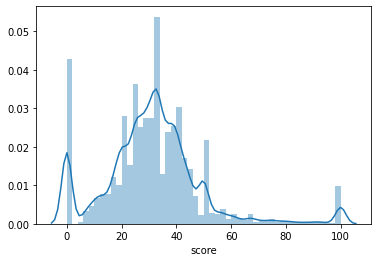

In [72]:
sns.distplot(evaluation.score)

### Evaluation Phase 2: Using Precision and Recall

## Precision

In [63]:
def relevance(x, threshold):
    all_predictions = x.groupby(['prediction']).agg({'score': 'max'}).reset_index()
    found_predictions = len(all_predictions[all_predictions['score'] >= threshold])
    return found_predictions, len(all_predictions)

In [64]:
threshold_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
all_relevant_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    relevant_predictions = evaluation.groupby(['pn_num']).apply(lambda x: relevance(x, threshold=threshold_val))
    relevant_predictions = relevant_predictions.reset_index()
    relevant_predictions = pd.DataFrame(relevant_predictions[0].tolist(), index=relevant_predictions.pn_num)\
                            .rename(columns={0:f'found_labels', 1:f'total_predictions'})\
                            .reset_index()
    relevant_predictions[f'precision'] = relevant_predictions[f'found_labels'] / relevant_predictions[f'total_predictions']
    relevant_predictions['threshold'] = threshold_val
    all_relevant_predictions = pd.concat([all_relevant_predictions, relevant_predictions], axis=0)

## Recall

In [65]:
def retrieval(x, threshold):
    all_labels = x.groupby(['ground_truth_annotation']).agg({'score': 'max'}).reset_index()
    found_labels = len(all_labels[all_labels['score'] >= threshold])
    total_predictions = x['prediction'].nunique()
    
    return found_labels, len(all_labels)

In [66]:
threshold_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
all_retrieved_predictions = pd.DataFrame()

for threshold_val in threshold_values:
    retrieved_labels = evaluation.groupby(['pn_num']).apply(lambda x: retrieval(x, threshold=threshold_val))
    retrieved_labels = retrieved_labels.reset_index()
    retrieved_labels = pd.DataFrame(retrieved_labels[0].tolist(), index=retrieved_labels.pn_num)\
                        .rename(columns={0:f'found_predictions', 1:f'total_labels'})\
                        .reset_index()
    retrieved_labels['recall'] = retrieved_labels[f'found_predictions'] / retrieved_labels[f'total_labels']
    retrieved_labels['threshold'] = threshold_val
    all_retrieved_predictions = pd.concat([all_retrieved_predictions, retrieved_labels], axis=0)

In [67]:
evaluation_df = all_retrieved_predictions.merge(all_relevant_predictions, how='left', on=['pn_num', 'threshold'])
evaluation_df = evaluation_df[['pn_num', 'threshold', 'total_labels', 'total_predictions', 'found_labels', 'found_predictions', 'recall', 'precision']]

evaluation_df['f1_score'] = 2 * (evaluation_df['recall'] * evaluation_df['precision']) / (evaluation_df['recall'] + evaluation_df['precision'])
evaluation_df

,pn_num,threshold,total_labels,total_predictions,found_labels,found_predictions,recall,precision,f1_score
0,16,10,13,8,8,12,0.923077,1.000000,0.960000
1,41,10,9,6,5,6,0.666667,0.833333,0.740741
2,46,10,12,8,8,10,0.833333,1.000000,0.909091
3,82,10,13,9,9,12,0.923077,1.000000,0.960000
4,100,10,10,8,8,10,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...
9995,95145,100,12,8,4,3,0.250000,0.500000,0.333333
9996,95228,100,7,8,1,1,0.142857,0.125000,0.133333
9997,95243,100,10,7,0,0,0.000000,0.000000,NaN
9998,95330,100,16,8,2,2,0.125000,0.250000,0.166667


In [68]:
evaluation_df[evaluation_df.pn_num==16]

,pn_num,threshold,total_labels,total_predictions,found_labels,found_predictions,recall,precision,f1_score
0,16,10,13,8,8,12,0.923077,1.000,0.960000
1000,16,20,13,8,8,12,0.923077,1.000,0.960000
2000,16,30,13,8,8,12,0.923077,1.000,0.960000
3000,16,40,13,8,8,10,0.769231,1.000,0.869565
4000,16,50,13,8,6,8,0.615385,0.750,0.676056
5000,16,60,13,8,4,4,0.307692,0.500,0.380952
6000,16,70,13,8,3,3,0.230769,0.375,0.285714
7000,16,80,13,8,3,3,0.230769,0.375,0.285714
8000,16,90,13,8,2,2,0.153846,0.250,0.190476
9000,16,100,13,8,2,1,0.076923,0.250,0.117647


In [69]:
biomedNLP_evaluation = evaluation_df.merge(test,on="pn_num",how="left")

In [70]:
biomedNLP_evaluation.to_csv("biomedNLP_evaluation_evaluation.csv", index=False)

In [71]:
evaluation_df.to_csv("biomedNLP_evaluation_evaluation_scores.csv",index=False)

### -----x-------x